## Agent / Graph for Maxit 

This notebook will implement the 
"RM-Agent" 
"peer-comparison" , "debt profiling" "sub-agents" for Maxit.  

In [3]:
%%capture --no-stderr
%pip install -U langgraph

In [27]:
from langgraph.graph import START, StateGraph
from typing import TypedDict

### Sub Graph Per Comparison 

In [28]:
# Define sub-graph peer-comparison 
from typing import TypedDict, List, Literal, Optional

class PeerComparisonState(TypedDict, total=False):
    framework_id: Literal["peer_comparison"]
    query: str
    client_id: str
    peer_ids: List[str]
    industry_id: Optional[str]
    financials: dict  # {ticker: {...}} format
    comparison_results: dict  # task_name -> result summary
    missing_data: List[str]
    response_trace: List[str]
    memory_refs: List[str]



In [29]:
from langgraph.graph import StateGraph

class PeerComparisonGraph:
    def __init__(self):
        self.graph = self._build_graph()

    def _build_graph(self):
        graph = StateGraph(PeerComparisonState)

        graph.add_node("load_financials", self.load_financial_data)
        graph.add_node("revenue_comparison", self.revenue_comparison)
        graph.add_node("cost_structure_comparison", self.cost_structure_comparison)
        graph.add_node("profitability_comparison", self.profitability_comparison)
        graph.add_node("leverage_comparison", self.leverage_comparison)
        graph.add_node("peer_scoring_summary", self.peer_scoring_summary)

        graph.set_entry_point("load_financials")

        graph.add_edge("load_financials", "revenue_comparison")
        graph.add_edge("revenue_comparison", "cost_structure_comparison")
        graph.add_edge("cost_structure_comparison", "profitability_comparison")
        graph.add_edge("profitability_comparison", "leverage_comparison")
        graph.add_edge("leverage_comparison", "peer_scoring_summary")

        return graph

    def load_financial_data(self, state: PeerComparisonState) -> PeerComparisonState:
        # Pulls data from external/ar, internal/c360, etc.
        updated_state=None
        return updated_state

    def revenue_comparison(self, state: PeerComparisonState) -> PeerComparisonState:
        updated_state=None
        return updated_state

    def cost_structure_comparison(self, state: PeerComparisonState) -> PeerComparisonState:
        updated_state=None
        return updated_state

    def profitability_comparison(self, state: PeerComparisonState) -> PeerComparisonState:
        updated_state=None
        return updated_state

    def leverage_comparison(self, state: PeerComparisonState) -> PeerComparisonState:
        updated_state=None
        return updated_state

    def peer_scoring_summary(self, state: PeerComparisonState) -> PeerComparisonState:
        final_state=None
        return final_state


### Sub-Graph 'Debt Profiling'

In [30]:

from typing import TypedDict, List, Optional, Literal

class DebtProfilingState(TypedDict, total=False):
    framework_id: Literal["debt_profiling"]
    query: str
    client_id: str
    industry_id: Optional[str]
    financials: dict            # { "XYZ": { "debt": ..., "cash": ..., ... } }
    debt_metrics: dict          # e.g., { "Debt/Equity": 1.2, "NetDebt/EBITDA": 3.1 }
    benchmark_metrics: dict     # e.g., industry or peer group averages
    interpretation: str         # final LLM output: "Moderate leverage, room to borrow"
    memory_refs: List[str]


In [31]:
from langgraph.graph import StateGraph


class DebtProfilingGraph:
    def __init__(self):
        self.graph = self._build_graph()

    def _build_graph(self):
        graph = StateGraph(DebtProfilingState)

        # Add LangGraph nodes
        graph.add_node("load_financial_data", self.load_financial_data)
        graph.add_node("calculate_debt_metrics", self.calculate_debt_metrics)
        graph.add_node("fetch_peer_benchmarks", self.fetch_peer_benchmarks)
        graph.add_node("compare_vs_benchmark", self.compare_vs_benchmark)
        graph.add_node("synthesize_debt_profile", self.synthesize_debt_profile)

        # Wire up nodes
        graph.set_entry_point("load_financial_data")
        graph.add_edge("load_financial_data", "calculate_debt_metrics")
        graph.add_edge("calculate_debt_metrics", "fetch_peer_benchmarks")
        graph.add_edge("fetch_peer_benchmarks", "compare_vs_benchmark")
        graph.add_edge("compare_vs_benchmark", "synthesize_debt_profile")

        return graph

    # === LangGraph node functions ===

    def load_financial_data(self, state: DebtProfilingState) -> DebtProfilingState:
        # Pull from namespace like external/ar/company/{ticker}
        # Extract Total Debt, Cash, EBITDA, Equity
        financials = {
            "total_debt": 3200,
            "cash": 800,
            "ebitda": 1020,
            "equity": 2700,
        }
        state["financials"] = financials
        return state

    def calculate_debt_metrics(self, state: DebtProfilingState) -> DebtProfilingState:
        f = state["financials"]
        state["debt_metrics"] = {
            "Debt/Equity": round(f["total_debt"] / f["equity"], 2),
            "NetDebt/EBITDA": round((f["total_debt"] - f["cash"]) / f["ebitda"], 2),
        }
        return state

    def fetch_peer_benchmarks(self, state: DebtProfilingState) -> DebtProfilingState:
        # Dummy industry or peer benchmarks
        state["benchmark_metrics"] = {
            "Debt/Equity": 1.1,
            "NetDebt/EBITDA": 2.7
        }
        return state

    def compare_vs_benchmark(self, state: DebtProfilingState) -> DebtProfilingState:
        # Optionally store deltas or annotate deviations
        metrics = state["debt_metrics"]
        peers = state["benchmark_metrics"]
        interpretation = {
            k: "above average" if metrics[k] > peers[k] else "below average"
            for k in metrics
        }
        state["interpretation_summary"] = interpretation
        return state

    def synthesize_debt_profile(self, state: DebtProfilingState) -> DebtProfilingState:
        interpretation = state.get("interpretation_summary", {})
        summary = (
            f"Debt/Equity is {interpretation.get('Debt/Equity')}, "
            f"Net Debt/EBITDA is {interpretation.get('NetDebt/EBITDA')} — "
            f"overall leverage is {'moderate to high' if 'above average' in interpretation.values() else 'within industry norms'}."
        )
        state["interpretation"] = summary
        return state


### Define the RM Agent 

In [32]:
from typing import TypedDict, Literal
from langgraph.graph import START, StateGraph

class RMAgentState(TypedDict, total=False):
    query: str
    client_id: str
    framework_id: Literal["peer_comparison", "debt_profiling"]
    result: str


In [46]:
def detect_framework(state: RMAgentState) -> RMAgentState:
    # Dummy logic for example purposes
    if "compare" in state["query"]:
        state["framework_id"] = "peer_comparison"
    else:
        state["framework_id"] = "debt_profiling"
    return state

def route_to_subgraph(state: RMAgentState) -> str:
    return state["framework_id"]  # Must match subgraph node names

def finalize_response(state: RMAgentState) -> RMAgentState:
    return state 


In [47]:
# Import your sub-agent graphs
peer_comparison_graph = PeerComparisonGraph().graph.compile()
debt_profiling_graph = DebtProfilingGraph().graph.compile()

# Build the parent RM Agent graph
rm_graph_builder = StateGraph(RMAgentState)

rm_graph_builder.add_node("detect_framework", detect_framework)

# Add sub-agent graphs by name
rm_graph_builder.add_node("peer_comparison", peer_comparison_graph)
rm_graph_builder.add_node("debt_profiling", debt_profiling_graph)

# Routing logic
rm_graph_builder.set_entry_point("detect_framework")
rm_graph_builder.add_conditional_edges("detect_framework", route_to_subgraph)

# Ending State 
rm_graph_builder.add_node("finalize_response", finalize_response)
rm_graph_builder.add_edge("peer_comparison", "finalize_response")
rm_graph_builder.add_edge("debt_profiling", "finalize_response")
rm_graph_builder.add_edge("finalize_response", "__end__")

# Final graph
rm_agent_graph = rm_graph_builder.compile()

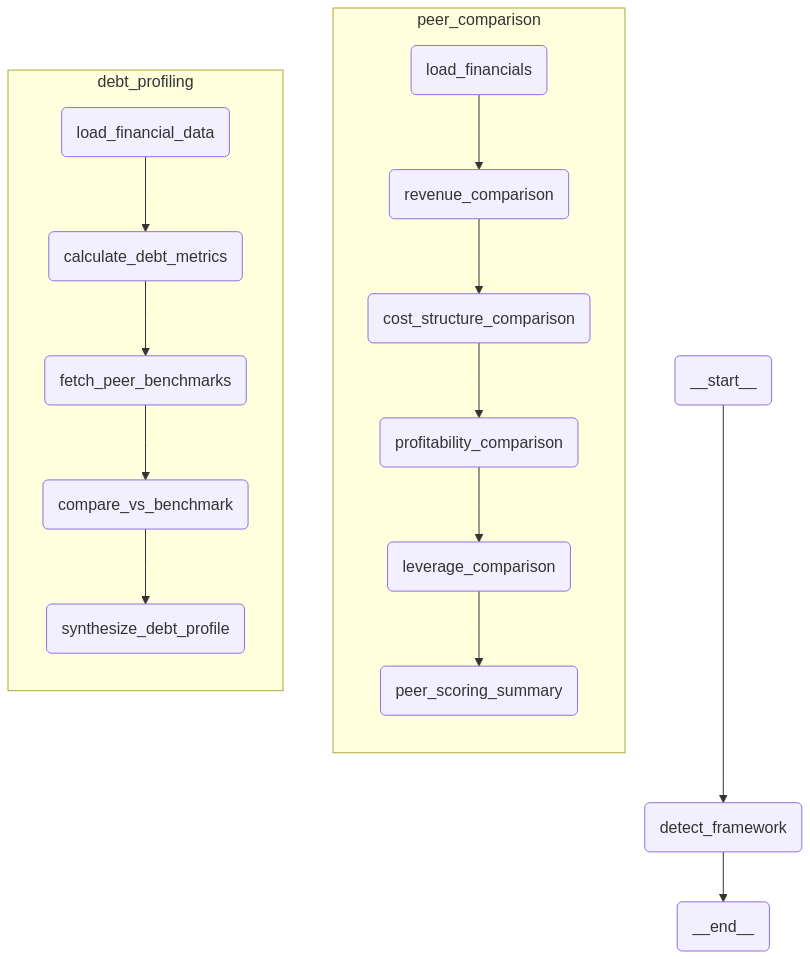

In [36]:
from IPython.display import Image, display
# Setting array to 1 will show the internal structure of the nested graph
display(Image(rm_agent_graph.get_graph(xray=1).draw_mermaid_png()))

In [50]:
initial_state = {
    "query": "How does XYZ compare do on profitability?",
    "client_id": "xyz"
}

res_state = rm_agent_graph.invoke(initial_state)
print(res_state)

{'query': 'How does XYZ compare do on profitability?', 'client_id': 'xyz', 'framework_id': 'peer_comparison'}
